In [59]:
# %pip install numpy pandas matplotlib seaborn
# %pip install geopandas
# %pip install contextily
# %pip install scikit-learn

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import KDTree
import requests

In [61]:
import pandas as pd

# AE -> Administrative Entities (the name of the library system) 
# Outlets -> AE's can have multiple branches (i.e. West Library, East Library, etc)
ae_df = pd.read_csv('../data/libraries_2019/PLS_FY19_AE_pud19i.csv', encoding='latin-1')
outlets_df = pd.read_csv("../data/libraries_2019/PLS_FY19_Outlet_pud19i.csv", encoding='latin-1')


ae_df['geometry'] = ae_df.apply(lambda row: Point(row['LATITUDE'], row['LONGITUD']), axis=1)
ae_df = ae_df[ae_df['STABR'] != 'PR']
outlets_df['geometry'] = outlets_df.apply(lambda row: Point(row['LATITUDE'], row['LONGITUD']), axis=1)
outlets_df = outlets_df[outlets_df['STABR'] != 'PR']

# gdf = gpd.GeoDataFrame(outlets_df, geometry='geometry')
# gdf = gdf.set_crs("EPSG:4326")

# Census Tracts
tracts = gpd.read_file('../data/tracts_2020/US_tract_2020.shp')
tracts["LATITUDE"] = tracts['INTPTLAT'].astype(float)
tracts["LONGITUD"] = tracts['INTPTLON'].astype(float)
tracts = tracts.to_crs("EPSG:4326")


# Convert fips to state abbreviation for merging
fip_to_abbr = {'01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'}
tracts['state'] = tracts['STATEFP'].map(fip_to_abbr)

tracts = tracts[tracts['state'] != 'PR']


# GLOBAL DATA FRAMES:
state_df = None



## Library Access and Density

- How does the number of public libraries per capita vary across different regions and states?
- Are there any "library deserts" where access to libraries is particularly low?


### Library Access
Library per capita & libraries per person. Analyzed each state.

In [62]:
### Public Libraries Per Capita (State)

state_df = pd.read_csv('../data/state_populations.csv')
state_df['population'] = state_df['population'].str.replace(',', '').astype(int)

# Number of libraries per state
outlets_df.groupby('STABR').size().sort_values(ascending=False)

# Number of libraries per state per capita
state_df['libraries'] = state_df['state'].map(outlets_df.groupby('STABR').size())

# Calculate libraries per capita and people per library
state_df['libraries_per_capita'] = state_df['libraries'] / state_df['population']
state_df['capita_per_library'] = state_df['population'] / state_df['libraries']



### Library Deserts


In [63]:
# The goal is to get the closest library's distance for each census tract. I used a KDTree to find the nearest library to each census tract. To handle distance, I used the haversine distance formula to calculate the distance between two points on the Earth's surface.

# Got coordinates as just a np array
library_coords = outlets_df[['LATITUDE', 'LONGITUD']].values
tract_coords = tracts[['LATITUDE', 'LONGITUD']].values

# Constructed KDTree (basically more efficient than brute force)
kdtree = KDTree(library_coords)

# Query KDTree to find nearest library to each tract
distances, indices = kdtree.query(tract_coords)
haversine_distances = []

# Haversine distance formula (in km, to account for Earth's curvature)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

# Calculate haversine distance between each tract and its nearest library
for i, tract in enumerate(tract_coords):
    nearest_index = indices[i][0]
    library = library_coords[nearest_index]
    distance = haversine_distance(tract[0], tract[1], library[0], library[1])
    haversine_distances.append(distance)

tracts['km_to_library'] = haversine_distances

# Ultimately, we'll be able to use km_to_library as a proxy for the level of library access a given census tract / community has.

## Race & Library Access

- What is the correlation between the racial/ethnic composition of a region and the density or accessibility of public libraries?
- How do libraries serve communities with high percentages of minority populations?


In [64]:
"""
** RUN ONLY ONCE ** 
County-level access to libraries (km)

"""

counties = pd.read_csv('../data/county_demographics.csv', encoding='latin-1')

tracts['GISJOIN_CTY'] = tracts['GISJOIN'].str[:8]

# Makes new columns for percentages
races = ['White', 'Black', 'Indigenous', 'Asian', 'Hawaiian', 'Other', 'Two_Races']
urban_or_rural = ['Rural', 'Urban']

# Get percentages for race and urban/rural
for race in races:
  counties[f"{race}_pct"] = counties[race] * 100 / counties['U7J001']
  
for urban in urban_or_rural:
  counties[f"{urban}_pct"] = counties[urban] * 100 / counties['U7I001']

# For each county, use describe() to get stats on distance to library 
county_accessibility = tracts.groupby('GISJOIN_CTY')['km_to_library'].describe()
county_accessibility = county_accessibility.reset_index()

# Get stats on km_to_library for each county
county_accessibility.columns = ['GISJOIN', 'count', 'mean_km_to_library', 'std_km_to_library', 'min_km_to_library', '25%', '50%', '75%', 'max_km_to_library']
counties = counties.merge(county_accessibility, on='GISJOIN', how='left')


"""

Tract-level access to libraries (km)

"""

tract_demographics = pd.read_csv('../data/tract_demographics.csv', encoding='latin-1')

for race in races:
  tract_demographics[f"{race}_pct"] = tract_demographics[race] * 100 / tract_demographics['U7J001']
  
for urban in urban_or_rural:
  tract_demographics[f"{urban}_pct"] = tract_demographics[urban] * 100 / tract_demographics['U7I001']

tracts = tracts.merge(tract_demographics[['GISJOIN','U7I001', 'Urban',
       'Rural', 'U7I004', 'U7J001', 'White', 'Black', 'Indigenous', 'Asian',
       'Hawaiian', 'Other', 'Two_Races', 'White_pct', 'Black_pct',
       'Indigenous_pct', 'Asian_pct', 'Hawaiian_pct', 'Other_pct',
       'Two_Races_pct', 'Rural_pct', 'Urban_pct']], on='GISJOIN', how='left')


tracts = tracts.fillna(0)

"""

Income-level access to libraries (km)

"""

income = pd.read_csv('../data/tract_income_demographics.csv', encoding='latin-1')
income = income[['GISJOIN', 'Income']]

tracts = tracts.merge(income, on='GISJOIN', how='left')

In [65]:
tracts['Income'].isna().sum()

np.int64(2092)

In [66]:
def remove_outliers(df, column):
  Q1 = df[column].quantile(0.05)
  Q3 = df[column].quantile(0.95)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

tracts = remove_outliers(tracts, 'km_to_library')
tracts = remove_outliers(tracts, 'Income')

In [67]:
from scipy.stats import ttest_ind
# Define a threshold for high percentage of Black residents
threshold = 50  # This can be adjusted based on the data distribution


# Split the data into two groups based on the threshold
high_black_pct = tracts[tracts['Black_pct'] > threshold]
low_black_pct = tracts[tracts['Black_pct'] <= threshold]

# Perform a t-test to compare the mean distances to libraries between the two groups
t_stat, p_value = ttest_ind(high_black_pct['km_to_library'], low_black_pct['km_to_library'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
  print("There is a statistically significant difference in library access between communities with high and low percentages of Black residents.")
else:
  print("There is no statistically significant difference in library access between communities with high and low percentages of Black residents.")

T-statistic: -46.53722357874254
P-value: 0.0
There is a statistically significant difference in library access between communities with high and low percentages of Black residents.


AttributeError: Line2D.set() got an unexpected keyword argument 'bins'

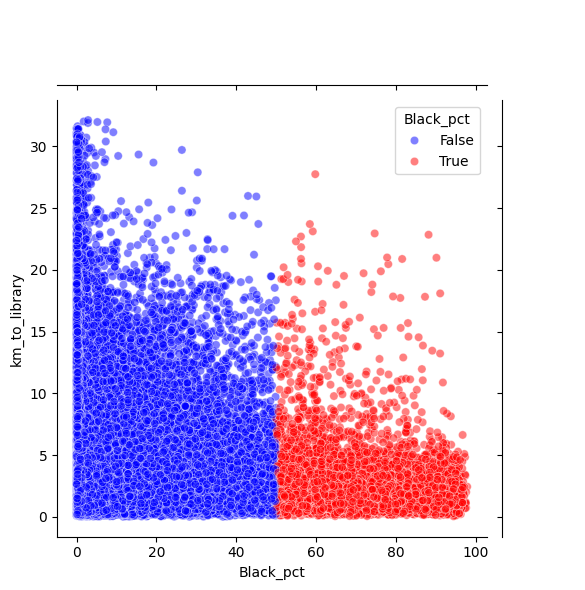

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with marginal histograms
g = sns.jointplot(
    x=tracts['Black_pct'],
    y=tracts['km_to_library'],
    hue=(tracts['Black_pct'] > threshold),
    palette={True: 'red', False: 'blue'},
    marginal_kws=dict(bins=50, fill=False),
    alpha=0.5
)

# Add titles and labels
g.set_axis_labels('Percentage of Black Residents', 'Distance to Nearest Library (km)')
g.fig.suptitle('Library Access by Percentage of Black Residents', y=1.02)

# Show the plot
plt.show()


In [68]:
print('hello')

hello


In [69]:
tracts.loc[tracts['U7J001'] == 0, 'Income'] = 0 # if the population is 0, set income to 0
tracts['Income'] = tracts['Income'].fillna(method='ffill') # flood fill the missing values (i.e. take the last known value, since data is sorted by GISJOIN)

C:\Users\Bryan Sukidi\AppData\Local\Temp\ipykernel_32976\2110473735.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tracts['Income'] = tracts['Income'].fillna(method='ffill') # flood fill the missing values (i.e. take the last known value, since data is sorted by GISJOIN)


In [70]:
tracts.columns

Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape_Leng', 'Shape_Area', 'geometry', 'LATITUDE',
       'LONGITUD', 'state', 'km_to_library', 'GISJOIN_CTY', 'U7I001', 'Urban',
       'Rural', 'U7I004', 'U7J001', 'White', 'Black', 'Indigenous', 'Asian',
       'Hawaiian', 'Other', 'Two_Races', 'White_pct', 'Black_pct',
       'Indigenous_pct', 'Asian_pct', 'Hawaiian_pct', 'Other_pct',
       'Two_Races_pct', 'Rural_pct', 'Urban_pct', 'Income'],
      dtype='object')

In [71]:
tracts

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,White_pct,Black_pct,Indigenous_pct,Asian_pct,Hawaiian_pct,Other_pct,Two_Races_pct,Rural_pct,Urban_pct,Income
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9.825304e+06,...,78.253521,12.000000,0.281690,0.450704,0.169014,1.971831,6.873239,15.661972,84.338028,60563.0
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3.320818e+06,...,40.973236,53.722628,0.097324,0.583942,0.194647,0.973236,3.454988,0.000000,100.000000,57460.0
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5.349271e+06,...,69.776119,22.201493,0.373134,0.435323,0.186567,1.523632,5.503731,0.093284,99.906716,77371.0
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6.384282e+06,...,84.267546,7.701366,0.400377,0.753650,0.023552,0.894960,5.958549,4.145078,95.854922,73191.0
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6.203654e+06,...,74.988431,14.622860,0.670986,2.151782,0.046275,1.341971,6.177696,0.000000,100.000000,79953.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84116,G5600430000200,56,043,000200,56043000200,2,Census Tract 2,G5020,S,5.780730e+09,...,89.646384,0.191144,0.860147,0.350430,0.000000,2.962727,5.989169,83.147499,16.852501,56627.0
84117,G5600430000301,56,043,000301,56043000301,3.01,Census Tract 3.01,G5020,S,1.993200e+06,...,81.487815,0.128260,1.410859,0.684053,0.042753,6.455750,9.790509,0.000000,100.000000,61087.0
84118,G5600430000302,56,043,000302,56043000302,3.02,Census Tract 3.02,G5020,S,1.542922e+07,...,85.183507,0.135931,0.770276,0.271862,0.090621,6.524694,7.023108,8.427730,91.572270,72634.0
84119,G5600450951100,56,045,951100,56045951100,9511,Census Tract 9511,G5020,S,6.100000e+09,...,90.707434,0.599520,1.618705,0.299760,0.149880,2.697842,3.926859,100.000000,0.000000,67715.0
